In [64]:
import os
import csv
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import rasterio
from rasterio.plot import show
from rasterio.crs import CRS
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import mask
from shapely.geometry import mapping
import json
from shapely.geometry import shape
from shapely.geometry import box
from pyproj import Transformer

# Polygon node summary bins

Inputs

In [65]:
# set project CRS (EPSG:4326 (world) or EPSG:32606 (Yukon Flats) or EPSG:7912 (ITRF2014))
TN_crs = "EPSG:32606" # currently using "epsg:32606" UTM 6N

# Tanana AOI (manually derived tight floodplain estimate that clips smallish sloughs)
TN_AOI_filepath = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/SWORD_clipped_TN_domain/TN_AOI_reduced.shp"
# water mask Tanana AOI generated from FODAR REM
# TN_AOI_filepath = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/vectorized_REM_watermask_1m.shp"

# need SWORD v16 when working with SWOT version C data
polygon_nodes_filepath = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/SWORD_clipped_TN_domain/polygon_nodes_v16.shp"

# directory with SWOT shapefile data 
# (SWOT data has been concatenated (tiles merged), clipped to the TN AOI, filtered to 10-60km swath, contains class 1 (land), 2 (land near water), 3 (water near land), 4 (open water), 5 (dark water))
# solid tide, load tide, pole tide all applied
swot_pixc_folder = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/SWOT/pixc/UTM6N_tidecorrections"

# directory with FODAR tifs
fodar_folder = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR"

CRS check

In [66]:
# Load TN AOI & SWORD polygon nodes
TN_AOI = gpd.read_file(TN_AOI_filepath)
polygon_nodes = gpd.read_file(polygon_nodes_filepath)

# Confirm data is in correct CRS 
TN_AOI = TN_AOI.to_crs(TN_crs)
polygon_nodes = polygon_nodes.to_crs(TN_crs)

print("TN AOI CRS:", TN_AOI.crs)
print("poly nodes CRS:", polygon_nodes.crs)

# print(len(polygon_nodes))
# print(polygon_nodes.head(5))

TN AOI CRS: EPSG:32606
poly nodes CRS: EPSG:32606


### PIXC processing

In [67]:
# Create CSV file for summary stats
# need to rerun this everytime before running the loop
summary_csv_path = os.path.join(swot_pixc_folder, "summaryStats_pixc_node_polygon_ellipsoid.csv")
csv_file = open(summary_csv_path, mode='w', newline='')
fieldnames = ['SWOTFileDate', 'node_id', 'reach_id', 'elev_mean_m', 'elev_median_m', 'elev_std_m', 'elev_10percentile_m', 'pixel_count',]
writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
writer.writeheader()

100

In [68]:
# List all SWOT shapefiles in the workspace & create list to loop through
SWOTshapefiles = [f for f in os.listdir(swot_pixc_folder) if f.startswith("2025") and f.endswith(".shp")]

len(SWOTshapefiles)

3

Create csv with averaged pixc for each domain node

In [70]:
# Iterate through all SWOT shapefiles
for SWOTshapefile in SWOTshapefiles:
    # Extract filename identifier
    SWOTfilename = os.path.basename(SWOTshapefile)[0:15]  

    # Load the SWOT shapefile & set the CRS
    swot_pixc = gpd.read_file(os.path.join(swot_pixc_folder, SWOTshapefile))
    swot_pixc = swot_pixc.to_crs(TN_crs)

    # Clip pixc to TN reduced AOI (extent of fodar coverage)
    SWOT_clipped = gpd.clip(swot_pixc, TN_AOI)
    


    # Iterate through each node to compute pixc node-averaged stats
    for idx, node in polygon_nodes.iterrows():
        # === Progress output ===
        print(f"Processing SWOT file '{SWOTfilename}'")

        # Clip SWOT pixels to within the current PT polygon only
        node_geom = node.geometry
        SWOT_clipped_to_node = gpd.clip(SWOT_clipped, gpd.GeoDataFrame(geometry=[node_geom], crs=TN_crs))
        #print(f"  Clipped SWOT pixels: {len(SWOT_clipped_to_node)}")

        if SWOT_clipped_to_node.empty:
            continue  # Skip if no pixels intersect the node polygon
        
        # Compute stats
        mean_wse = SWOT_clipped_to_node['hght_w_'].mean()
        median_wse = SWOT_clipped_to_node['hght_w_'].median()
        std_wse = SWOT_clipped_to_node['hght_w_'].std()
        tenth_percentile = np.percentile(SWOT_clipped_to_node['hght_w_'], 10)
        count = SWOT_clipped_to_node['hght_w_'].count()
        node_id = node['node_id']
        reach_id = node['reach_d']

        writer.writerow({
            'SWOTFileDate': SWOTfilename,
            'node_id': node_id,
            'reach_id': reach_id,
            'elev_mean_m': mean_wse,
            'elev_median_m': median_wse, 
            'elev_10percentile_m': tenth_percentile,
            'elev_std_m': std_wse, 
            'pixel_count': count
        })

Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '20250403T164914'
Processing SWOT file '202

### FODAR processing

In [14]:
# Create CSV file for summary stats
# need to rerun this everytime before running the loop
summary_csv_path = os.path.join(fodar_folder, "summaryStats_fodar_node_polygon_ellipsoid.csv")
csv_file = open(summary_csv_path, mode='w', newline='')
fieldnames = ['FODARFileDate', 'node_id', 'reach_id', 'elev_mean_m', 'elev_median_m', 'elev_std_m', 'elev_10percentile_m', 'pixel_count',]
writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
writer.writeheader()

101

In [15]:
# List all FODAR tifs in the workspace & create list to loop through
FODARtifs = [f for f in os.listdir(fodar_folder) if f.startswith("2025") and f.endswith("elev_clipped.tif")]

len(FODARtifs)

2

CRS Check

In [16]:
FODAR_dem = rasterio.open("/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250403_WGS84_UTM6N_dem_5m_106-127elev_clipped.tif")
print("DEM CRS:", FODAR_dem.crs)

FODAR_dem2 = rasterio.open("/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250323_WGS84_UTM6N_dem_5m_101-127elev_clipped.tif")
print("DEM CRS:", FODAR_dem2.crs)

DEM CRS: EPSG:32606
DEM CRS: EPSG:32606


In [17]:
# Elevation limits (determined by manual id of river heights in qgis)
elevation_min = 101
elevation_max = 127

# Iterate through all FODAR tifs
for FODARtif in FODARtifs:
    FODARfilename = os.path.basename(FODARtif)[0:8]

    with rasterio.open(os.path.join(fodar_folder, FODARtif)) as FODAR:
        print(f"Clipping and filtering FODAR raster: {FODARfilename}")

        # Clip raster to TN AOI extent
        try:
            FODAR_clipped, clipped_transform = rasterio.mask.mask(
                FODAR, TN_AOI.geometry.values, crop=True)
        except ValueError:
            print("  No overlap between FODAR and AOI extent.")
            continue

        # Extract raster data
        data = FODAR_clipped[0]
        nodata_val = FODAR.nodata if FODAR.nodata is not None else -9999

        # Apply elevation mask to the AOI-clipped raster
        data = np.where(
            (data >= elevation_min) & (data <= elevation_max),
            data,
            nodata_val
        )

        # === Iterate over each node ===
        for idx, node in polygon_nodes.iterrows():
            print(f"  Processing Node ID: {node['node_id']}")

            # Re-mask *the original FODAR* again by node polygon (NOT ideal but fine)
            try:
                node_geom = [mapping(node.geometry)]
                node_masked, _ = rasterio.mask.mask(
                    FODAR, node_geom, crop=True)
            except ValueError:
                continue  # Skip if geometry doesn't intersect raster

            node_data = node_masked[0]
            node_data = np.where(
                (node_data >= elevation_min) & (node_data <= elevation_max),
                node_data,
                nodata_val
            )

            valid_data = node_data[node_data != nodata_val]

            if valid_data.size == 0:
                continue

            # Compute stats
            mean_elev = np.mean(valid_data)
            median_elev = np.median(valid_data)
            std_elev = np.std(valid_data)
            tenth_percentile = np.percentile(valid_data, 10)
            count = valid_data.size
            node_id = node['node_id']
            reach_id = node['reach_d']

            writer.writerow({
                'FODARFileDate': FODARfilename,
                'node_id': node_id,
                'reach_id': reach_id,
                'elev_mean_m': mean_elev,
                'elev_median_m': median_elev,
                'elev_std_m': std_elev,
                'elev_10percentile_m': tenth_percentile,
                'pixel_count': count
            })


Clipping and filtering FODAR raster: 20250323
  Processing Node ID: 81245000010301
  Processing Node ID: 81245000010311
  Processing Node ID: 81245000010321
  Processing Node ID: 81245000010331
  Processing Node ID: 81245000010341
  Processing Node ID: 81245000010351
  Processing Node ID: 81245000010361
  Processing Node ID: 81245000010371
  Processing Node ID: 81245000010381
  Processing Node ID: 81245000010391
  Processing Node ID: 81245000010401
  Processing Node ID: 81245000010411
  Processing Node ID: 81245000010421
  Processing Node ID: 81245000010431
  Processing Node ID: 81245000010441
  Processing Node ID: 81245000010451
  Processing Node ID: 81245000010461
  Processing Node ID: 81245000010471
  Processing Node ID: 81245000010481
  Processing Node ID: 81245000010491
  Processing Node ID: 81245000010501
  Processing Node ID: 81245000010511
  Processing Node ID: 81245000010521
  Processing Node ID: 81245000010531
  Processing Node ID: 81245000010541
  Processing Node ID: 8124500

# Pixel to pixel comparisons

Inputs

In [79]:
# April 3 fodar
swot_pixc_filepath = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/SWOT/pixc/UTM6N_tidecorrections/20250403T164914.csv"
FODAR_filepath = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250403_WGS84_UTM6N_dem_5m_106-127elev_clipped.tif"

# March 23 fodar
# swot_pixc_filepath = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/SWOT/pixc/UTM6N_tidecorrections/20250322T031247.csv"
# swot_pixc_filepath = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/SWOT/pixc/UTM6N_tidecorrections/20250324T182659.csv"
# FODAR_filepath = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250323_WGS84_UTM6N_dem_5m_101-127elev_clipped.tif"

In [80]:
# open swot pixc
swot_pixc = pd.read_csv(swot_pixc_filepath)

# lat/lon column names
lon_col = 'longitude'
lat_col = 'latitude'

# CRS transform from WGS84 (EPSG:4326) -> UTM Zone 6N (EPSG:32606")
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32606", always_xy=True)
x_utm, y_utm = transformer.transform(swot_pixc[lon_col].values, swot_pixc[lat_col].values)

In [81]:
# Open FODAR DEM and sample at each pixc point
with rasterio.open(FODAR_filepath) as src:
    # Confirm raster CRS
    print(f"Raster CRS: {src.crs}")
    
    # Sample raster at UTM coords
    coords = list(zip(x_utm, y_utm))
    sampled_values = [val[0] for val in src.sample(coords)]

# Add heights to swot_pixc df
swot_pixc['FODAR_height'] = sampled_values

Raster CRS: EPSG:32606


In [82]:
# save updated csv
output_csv = os.path.splitext(swot_pixc_filepath)[0] + "_with_FODAR_height.csv"
swot_pixc.to_csv(output_csv, index=False)

print(f"Output saved to: {output_csv}")

Output saved to: /Users/camryn/Documents/UNC/Ice_caval/Tanana/SWOT/pixc/UTM6N_tidecorrections/20250403T164914_with_FODAR_height.csv


# Scratch

Water mask generation from FODAR REM

In [ ]:
# Input and output paths
input_raster_path = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250323_REM.tif"
output_raster_path = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250323_REM_watermask_1m.tif"

# Open the REM (input raster)
with rasterio.open(input_raster_path) as FODAR_REM:
    # Reproject AOI to match raster CRS
    TN_AOI_proj = TN_AOI.to_crs(FODAR_REM.crs) #should both be in ITRF14
    
    # Convert AOI geometry to GeoJSON-like format
    aoi_geom = [json.loads(TN_AOI_proj.to_json())['features'][0]['geometry']]
    
    # Clip
    FODAR_clipped, clipped_transform = mask.mask(FODAR_REM, aoi_geom, crop=True)
    clipped_meta = FODAR_REM.meta.copy()
    
    # Mask values over 1m to create water mask
    elevation_min = -10
    elevation_max = 1
    FODAR_clipped_masked = np.where(
        (FODAR_clipped >= elevation_min) & (FODAR_clipped <= elevation_max),
        FODAR_clipped,
        FODAR_REM.nodata if FODAR_REM.nodata is not None else -9999
    )

    # Update metadata for output
    clipped_meta.update({
        "driver": "GTiff",
        "height": FODAR_clipped.shape[1],
        "width": FODAR_clipped.shape[2],
        "transform": clipped_transform,
        "nodata": FODAR_REM.nodata if FODAR_REM.nodata is not None else -9999
    })

# Save the clipped raster
with rasterio.open(output_raster_path, "w", **clipped_meta) as dest:
    dest.write(FODAR_clipped_masked)


FODAR metadata info

In [ ]:
print(FODAR_dem.meta)
print(FODAR_dem.tags())

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 12379, 'height': 13435, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 6N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722356049,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32606"]]'), 'transform': Affine(5.0, 0.0, 372611.4409865337,
       0.0, -5.0, 7207128.6158801615)}
{'AREA_OR_POINT': 'Point'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 5734, 'height': 7335, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 6N",GEOGC

SWOT CRS info

In [ ]:
swot_path = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/SWOT/pixc/20250322T031247.shp"
gdf = gpd.read_file(swot_path)

# Print CRS info
print("CRS (short form):", gdf.crs)
print("\nCRS (WKT):\n", gdf.crs.to_wkt())


CRS (short form): EPSG:4326

CRS (WKT):
 GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],MEMBER["World Geodetic System 1984 (G2296)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]


Reproject FODAR tifs

In [77]:
# reproject FODAR tifs

# # Input and output paths
# input_raster_path = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/tanana_250323_all_dem_10m.tif"
# output_raster_path = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250323_all_dem_10m_utm6n.tif"

# # Open the source raster
# with rasterio.open(input_raster_path) as src:
#     transform, width, height = calculate_default_transform(
#         src.crs, TN_crs, src.width, src.height, *src.bounds)
    
#     kwargs = src.meta.copy()
#     kwargs.update({
#         'crs': TN_crs,
#         'transform': transform,
#         'width': width,
#         'height': height
#     })

#     # Create the output raster with the updated metadata
#     with rasterio.open(output_raster_path, 'w', **kwargs) as dst:
#         for i in range(1, src.count + 1):
#             reproject(
#                 source=rasterio.band(src, i),
#                 destination=rasterio.band(dst, i),
#                 src_transform=src.transform,
#                 src_crs=src.crs,
#                 dst_transform=transform,
#                 dst_crs=TN_crs,
#                 resampling=Resampling.bilinear  # Use bilinear or nearest depending on use case
#             )


In [ ]:
# Check number of polygon nodes and see df columns
#print(len(polygon_nodes))
#print(polygon_nodes.head(10))

# check pixc columns
#print(swot_pixc.columns.tolist())

Plot FODAR DEM with TN AOI

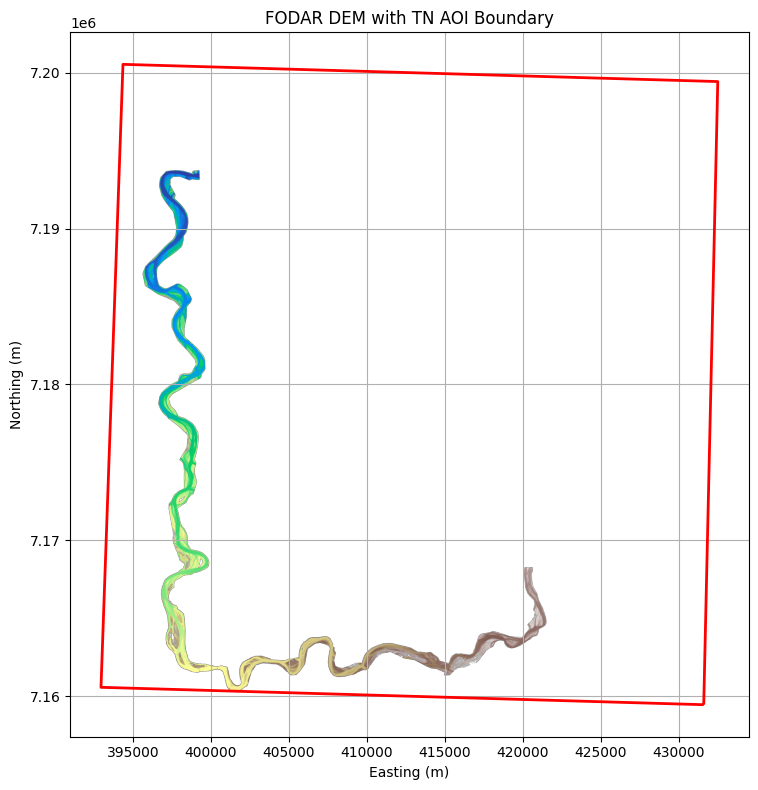

In [76]:
# Load raster
with rasterio.open("/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250403_WGS84_UTM6N_dem_5m_106-127elev_clipped.tif") as src:
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot DEM
    show(src, ax=ax, cmap='terrain')

    # Overlay AOI boundary
    TN_AOI_extent_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

    # Optional: label
    ax.set_title("FODAR DEM with TN AOI Boundary")
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Old way to clip FODAR to elevation bands

In [ ]:
# this is included in node polygon binning as of June 2025

# Input and output paths
input_raster_path = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250323_WGS84_UTM6N_dem_5m.tif"
output_raster_path = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250323_WGS84_UTM6N_dem_5m_101-127elev_clipped.tif"

# Open the source raster
with rasterio.open(input_raster_path) as FODAR_DEM:
    # Reproject AOI to match raster CRS
    TN_AOI_proj = TN_AOI.to_crs(FODAR_DEM.crs)
    
    # Convert AOI geometry to GeoJSON-like format
    aoi_geom = [json.loads(TN_AOI_proj.to_json())['features'][0]['geometry']]
    
    # Perform the clipping
    FODAR_clipped, clipped_transform = mask.mask(FODAR_DEM, aoi_geom, crop=True)
    clipped_meta = FODAR_DEM.meta.copy()
    
    # Mask values outside 95–115
    elevation_min = 101
    elevation_max = 127
    FODAR_clipped_masked = np.where(
        (FODAR_clipped >= elevation_min) & (FODAR_clipped <= elevation_max),
        FODAR_clipped,
        FODAR_DEM.nodata if FODAR_DEM.nodata is not None else -9999
    )

    # Update metadata for output
    clipped_meta.update({
        "driver": "GTiff",
        "height": FODAR_clipped.shape[1],
        "width": FODAR_clipped.shape[2],
        "transform": clipped_transform,
        "nodata": FODAR_DEM.nodata if FODAR_DEM.nodata is not None else -9999
    })

# Save the clipped raster
with rasterio.open(output_raster_path, "w", **clipped_meta) as dest:
    dest.write(FODAR_clipped_masked)


/var/folders/tz/g_8hxmvd0cb8yd6lk9pv5b500000gn/T/ipykernel_95958/2047053883.py:11: UserWarning: GeoDataFrame's CRS is not representable in URN OGC format. Resulting JSON will contain no CRS information.
  aoi_geom = [json.loads(TN_AOI_proj.to_json())['features'][0]['geometry']]


In [ ]:
# Plot FODAR_clipped raster
# fig, ax = plt.subplots(figsize=(10, 10))
# show(FODAR_clipped, transform=clipped_transform, ax=ax, cmap='terrain', title="FODAR Clipped with AOI")

# # Plot aoi_geom as shapely geometry
# aoi_shape = shape(aoi_geom[0])  # assumes aoi_geom is a list of one geometry dict
# gpd.GeoSeries([aoi_shape]).boundary.plot(ax=ax, edgecolor='red', linewidth=2)

# plt.show()

In [ ]:
# Output path
# output_tif = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250323_all_dem_10m_utm6n.tif"

# # Copy metadata from original FODAR_dem and update
# clipped_meta = FODAR_dem.meta.copy()
# clipped_meta.update({
#     "driver": "GTiff",
#     "height": FODAR_clipped.shape[1],  # rows
#     "width": FODAR_clipped.shape[2],   # cols
#     "transform": clipped_transform,
#     "count": 1  # single band
# })

# # Write the clipped raster to a new file
# with rasterio.open(output_tif, "w", **clipped_meta) as dest:
#     dest.write(FODAR_clipped[0], 1)  # write the first band


### SWOT metadata info

In [ ]:
import xarray as xr

# Load dataset
ds = xr.open_dataset("/Users/camryn/Documents/UNC/Ice_caval/Tanana/SWOT/pixc/SWOT_L2_HR_PIXC_030_136_039L_20250322T031247_20250322T031258_PIC2_01.nc")

# View variable names and dimensions
print(ds)


<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/65)
    Conventions:                                            CF-1.7
    title:                                                  Level 2 KaRIn Hig...
    institution:                                            CNES
    source:                                                 Ka-band radar int...
    history:                                                2025-03-25T21:57:...
    platform:                                               SWOT
    ...                                                     ...
    xref_pole_location_file:                                SMM_PO1_AXXCNE202...
    xref_geco_database_version:                             v102
    ellipsoid_semi_major_axis:                              6378137.0
    ellipsoid_flattening:                                   0.003352810664747...
    references:                                             1.3
    product_version:                         

In [2]:
import h5py

file_path = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/SWOT/pixc/SWOT_L2_HR_PIXC_030_136_039L_20250322T031247_20250322T031258_PIC2_01.nc"

with h5py.File(file_path, "r") as f:
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"{name}: shape = {obj.shape}, dtype = {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"{name}/")
    
    f.visititems(print_structure)


noise/
noise/noise_minus_y: shape = (22789,), dtype = float32
noise/noise_plus_y: shape = (22789,), dtype = float32
noise/num_lines: shape = (22789,), dtype = >f4
pixel_cloud/
pixel_cloud/ambiguity_cost1: shape = (4398107,), dtype = float32
pixel_cloud/ambiguity_cost2: shape = (4398107,), dtype = float32
pixel_cloud/ancillary_surface_classification_flag: shape = (4398107,), dtype = uint8
pixel_cloud/azimuth_index: shape = (4398107,), dtype = int32
pixel_cloud/bright_land_flag: shape = (4398107,), dtype = uint8
pixel_cloud/classification: shape = (4398107,), dtype = uint8
pixel_cloud/classification_qual: shape = (4398107,), dtype = uint32
pixel_cloud/coherent_power: shape = (4398107,), dtype = float32
pixel_cloud/complex_depth: shape = (2,), dtype = >f4
pixel_cloud/cross_track: shape = (4398107,), dtype = float32
pixel_cloud/darea_dheight: shape = (4398107,), dtype = float32
pixel_cloud/data_window_first_cross_track: shape = (3254,), dtype = float32
pixel_cloud/data_window_first_valid: 

Reproject raster

In [9]:

# Input and output files
input_dem = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250323_WGS84_UTM6N_dem_5m.tif"
output_dem = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250323_ITRF14_dem_5m.tif"


# Source CRS: WGS84 / UTM zone 6N
src_crs = CRS.from_epsg(32606)


# EPSG:7912 = ITRF2014
tgt_crs = CRS.from_epsg(7912)


# Open and reproject
with rasterio.open(input_dem) as src:
    transform, width, height = calculate_default_transform(
        src.crs, tgt_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': tgt_crs.to_wkt(),
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(output_dem, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=tgt_crs,
                resampling=Resampling.bilinear
            )


In [11]:
print(FODAR_dem.meta)
print(FODAR_dem.tags())

print(FODAR_dem2.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 8280, 'height': 4464, 'count': 1, 'crs': CRS.from_wkt('GEOGCRS["ITRF2014",DYNAMIC[FRAMEEPOCH[2010]],DATUM["International Terrestrial Reference Frame 2014",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,3],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],AXIS["ellipsoidal height (h)",up,ORDER[3],LENGTHUNIT["metre",1]],USAGE[SCOPE["Geodesy."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",7912]]'), 'transform': Affine(7.541789524305487e-05, 0.0, -149.23388684542934,
       0.0, -7.541789524305487e-05, 64.87754982956486)}
{'AREA_OR_POINT': 'Area'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 5734, 'height': 7335, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 6N",GEOGCS["

In [22]:
import rasterio
import numpy as np
import pandas as pd

# Input DEM path (EPSG:7912)
dem_path = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250403_ITRF2014_epoch2010_dem_5m.tif"

# Output CSV path
output_csv = "/Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250403_ITRF2014_epoch2010_dem_5m.csv"

# Open DEM
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)
    transform = src.transform
    width, height = src.width, src.height
    crs = src.crs

    # Check CRS is EPSG:7912
    print("CRS:", crs)
    if crs.to_epsg() != 7912:
        raise ValueError("The DEM CRS is not EPSG:7912!")

    # Get all pixel centers
    rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    lons, lats = rasterio.transform.xy(transform, rows, cols)
    lons = np.array(lons)
    lats = np.array(lats)

    # Flatten everything
    lats_flat = lats.flatten()
    lons_flat = lons.flatten()
    heights_flat = dem_data.flatten()

    # Mask nodata values if necessary
    mask = heights_flat != src.nodata if src.nodata is not None else ~np.isnan(heights_flat)
    lats_valid = lats_flat[mask]
    lons_valid = lons_flat[mask]
    heights_valid = heights_flat[mask]

    # Build dataframe
    df = pd.DataFrame({
        'latitude': lats_valid,
        'longitude': lons_valid,
        'height': heights_valid
    })

    # Write CSV
    df.to_csv(output_csv, index=False)

print(f"Export complete: {output_csv}")


CRS: EPSG:7912
Export complete: /Users/camryn/Documents/UNC/Ice_caval/Tanana/FODAR/20250403_ITRF2014_epoch2010_dem_5m.csv
